# Time Series Analysis Using ODM2

This notebook demonstrates basic time series data analysis using scientific Python libraries such as [NumPY](http://www.numpy.org/). This example uses water temperature data that is stored in a HydroShare TimeSeries resource to derive daily aggregated values and store the results in a new HydroShare resource.


## Script Setup and Preparation

Before we begin our processing, we must import several libaries into this notebook. The `ts_utils` library provides functions for interacting HydroShare Time Series Resources, including data querying and dowloading.  The `hs_utils` function provides general purpose functions for interacting with HydroShare.  The `%matplotlib inline` command tells the notebook server to place plots and figures directly into the notebook.

In [26]:
# import required libraries
import os
import ts_utils
import numpy as np
import collections
from pprint import pprint
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

Next we need to establish a secure connection with HydroShare. This is done by simply instantiating the hydroshare class that is defined within `ts_utils`. In addition to connecting with HydroShare, this command also sets environment variables for several parameters that may useful to you:

1. Your username
2. The ID of the resource which launched the notebook
3. The type of resource that launched this notebook
4. The url for the notebook server.

In [2]:
# establish a secure connection to HydroShare
ts = ts_utils.timeseries()

Adding the following system variables:
   HS_USR_NAME = JohnDoe
   HS_RES_ID = 6ee06abb2ed8414f9b66d229c8e9a129
   HS_RES_TYPE = rasterresource
   JUPYTER_HUB_IP = jupyter.uwrl.usu.edu

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => JohnDoe


### Retrieve a time series resource using its ID

This example uses water temperature data that is stored in HydroShare at the following url: https://www.hydroshare.org/resource/c6df8c1f22a0452b8035198e72967364/ . The data for our processing routines can be retrieved using the `getTimeSeriesResource` function by passing it the global identifier from the url above.  Alternatively, you can invoke the `getTimeSeriesResource` function without any arguments to retrieve data for the resource that launched your JupyterHub instance from HydroShare.

In [4]:
# Invoke the getTimeSeriesResource with the following guid to download 
# Water temperature data from the Little Bear River, UT
#
# ts.getTimeSeriesResource('c6df8c1f22a0452b8035198e72967364')

# Alternatively, invoke the getTimeSeriesResource without any arguments
# to download the content for the resource that you launched in HydroShare
ts.getTimeSeriesResource()

It looks like you have launched JupyterHub from a resource with the id: 6ee06abb2ed8414f9b66d229c8e9a129.
Would you like to download content for this resource? [Y/n/e] n
Enter the resource id to download: c6df8c1f22a0452b8035198e72967364

This resource already exists in your userspace.
Would you like to overwrite this data [y/N]? 


ODM2_single_site_multi_variable.sqlite


## Explore the Database Contents

TimeSeries resources consist of data stored in the Observations Data Model version 2. We can use the `ts_utils` and `odm2api` libraries to explore the contents of the database.  For more information on `odm2api` functions see https://github.com/ODM2/ODM2PythonAPI or issue the following command:

`help(odm2api)`

In [5]:
# display all variables inside the database
print('\n-------- Variables ---------')
print('%-10s %-10s\n%-10s %-10s' % ('Code', 'Name', '----','----'))
for x in ts.read.getVariables():
    print('%-10s %-10s' % (x.VariableCode, x.VariableNameCV))
print('----------------------------')


-------- Variables ---------
Code       Name      
----       ----      
USU36      Temperature
----------------------------


In [6]:
# Get all of the people from the database
print('\n-------- People ---------')
print('%-10s %-10s\n%-10s %-10s' % ('First', 'Last', '-----','-----'))
for x in ts.read.getPeople():
    print('%-10s %-10s' % (x.PersonFirstName, x.PersonLastName))
print('----------------------------')


-------- People ---------
First      Last      
-----      -----     
Jeff       Horsburgh 
----------------------------


In [7]:
# Get all of the SamplingFeatures from the database that are Sites
siteFeatures = ts.read.getSamplingFeatures(type='Site')
print('\n-------------------------------- Sites ---------------------------------')
print('%-20s %-20s\n%-20s %-20s' % ('Code', 'Name', '-----','-----'))
for x in siteFeatures:
        print('%-20s %-20s' % (x.SamplingFeatureCode, x.SamplingFeatureName[:50]))
print('--------------------------------------------------------------------------')


-------------------------------- Sites ---------------------------------
Code                 Name                
-----                -----               
USU-LBR-Mendon       Little Bear River at Mendon Road near Mendon, Utah
USU-LBR-Paradise     Little Bear River at McMurdy Hollow near Paradise,
USU-LBR-Wellsville   Little Bear River near Wellsville, Utah
USU-LBR-Confluence   Little Bear River below Confluence of South and Ea
USU-LBR-EFLower      East Fork Little Bear River at Paradise Canal Dive
USU-LBR-SFLower      South Fork Little Bear River below Davenport Creek
USU-LBR-SFUpper      South Fork Little Bear River above Davenport Creek
--------------------------------------------------------------------------


In [8]:
# read the results into the ts_utils library
results = ts.readResults()
print('\n-------------------------------- Results ---------------------------------')
print('%-10s %-10s %-10s %-20s %-20s' % ('ResultID','VariableID','ValueCount','VariableName','FeatureCode'))
for x in results.values():
    print('%-10d %-10s %-10d %-20s %-20s' % (x.ResultID,
                                          x.VariableID,
                                          x.ValueCount,
                                          x.VariableObj.VariableNameCV,
                                          x.FeatureActionObj.SamplingFeatureObj.SamplingFeatureCode))
print('--------------------------------------------------------------------------')



-------------------------------- Results ---------------------------------
ResultID   VariableID ValueCount VariableName         FeatureCode         
1          1          1441       Temperature          USU-LBR-Mendon      
2          1          1334       Temperature          USU-LBR-Paradise    
3          1          1441       Temperature          USU-LBR-Wellsville  
4          1          1441       Temperature          USU-LBR-Confluence  
5          1          1441       Temperature          USU-LBR-EFLower     
6          1          1441       Temperature          USU-LBR-SFLower     
7          1          1441       Temperature          USU-LBR-SFUpper     
--------------------------------------------------------------------------


## Parse the datavalues from the ODM2 database

Now that we've explored some of the data in the odm2 database, we can use the `ts_utils` library to parse the data into objects.  These object provide an easy way for us to preview, plot, and retrieve the datavalues associated the each time series result.

In [9]:
# read the timeseries values for result ids 1,2, and 3 into memory
ts.readTsValues([1,2,3])

Processing -> Temperature: Little Bear River at Mendon Road near Mendon, Utah
Processing -> Temperature: Little Bear River at McMurdy Hollow near Paradise, Utah
Processing -> Temperature: Little Bear River near Wellsville, Utah


In [10]:
# preview these data
ts.previewTs([1,2,3])

-----------------------------------------------------------------------
 ResultID: 1                                                         
 Temperature: Little Bear River at Mendon Road near Mendon, Utah     
-----------------------------------------------------------------------
DataValue                 ValueDateTime             
2008-01-01 00:00:00       0.1766667                 
2008-01-01 00:30:00       0.145                     
2008-01-01 01:00:00       0.05666667                
2008-01-01 01:30:00       0.01666667                
2008-01-01 02:00:00       -0.01166667               


----------------------------------------------------------------------------
 ResultID: 2                                                              
 Temperature: Little Bear River at McMurdy Hollow near Paradise, Utah     
----------------------------------------------------------------------------
DataValue                 ValueDateTime             
2008-01-01 10:00:00       0.025        

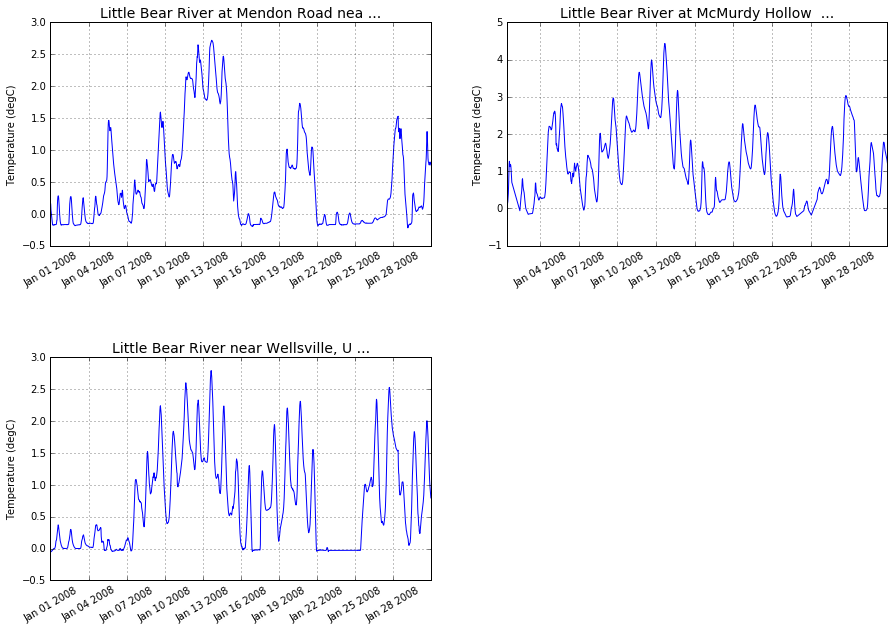

In [11]:
# preview the data as set of subplots
ts.subplotTimeSeries(ids=[1,2,3], cols=2)

Need to prepare the data for one or more of these result ids
Processing -> Temperature: Little Bear River below Confluence of South and East Forks near Avon, Utah




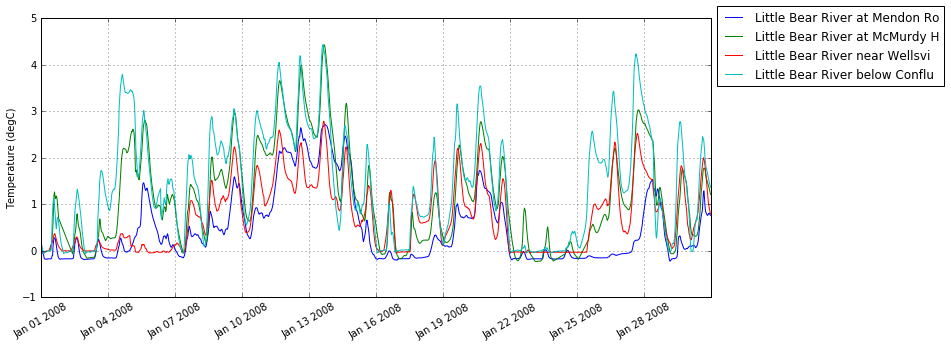

In [12]:
# plot multiple data series on a single graph
ts.plotTimeSeries(ids=[1,2,3,4])

## Data Analysis

The data previewing (above) isolate a single dataset to analyze.  In this example, we will be calculating the minimum, maximum, and average water temperature values for a `ResultID=1`: *Little Bear River at Mendon Road near Mendon, UT*. 

First, group the temperature datavalues by day.

In [13]:
# get the data that we want to analyze
data = ts.tsvalues[1]  # pandas dataframe
res = ts.tsresults[1]  # odm2result object

dates = [datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S') for d in data['ValueDateTime']]
vals = data['DataValue']

# group the temperature data by day
start = dates[0]
lenperiod = 1  # 1 day

# lists to hold the grouped temperatures and dates
gv = collections.OrderedDict() 
for i in range(len(dates)):
    date = dates[i].strftime('%m-%d-%Y')
    if date in gv.keys():
        gv[date].append(vals[i])
    else:
        gv[date] = [vals[i]]

Next, we will summarize the daily aggregated water temperatures and calculate daily minimum, maximum, and average values.

In [14]:
# initialize the t_min, t_max, and t_ave arrays
t_min = np.full((len(gv), 1),  9999, dtype=np.float)
t_max = np.full((len(gv), 1), -9999, dtype=np.float)
t_ave = np.full((len(gv), 1), 0, dtype=np.float)

# loop over every day
date_idx = 0
for date in gv.iterkeys():
    temp_count = 0
    # loop over each recorded temperature 
    for temp in gv[date]:        
        # save the min temp
        if temp < t_min[date_idx]:
            t_min[date_idx] = temp
        # save the max temp
        if temp > t_max[date_idx]:
            t_max[date_idx] = temp
        # sum the temps
        t_ave[date_idx] += temp
        temp_count += 1

    # calculate the average temp
    t_ave[date_idx] = (t_ave[date_idx] / temp_count).round(2)
    
    date_idx += 1

Now that the water temperature data is aggregated and summarized, we can preview the results using `matplotlib`

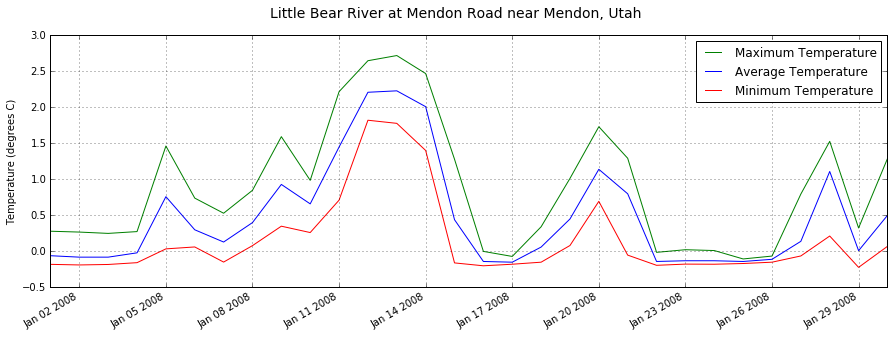

In [15]:
# create a figure
fig, ax = plt.subplots(1,1,figsize=(15, 5))

 # plot each temperature time series
x = [datetime.strptime(d, '%m-%d-%Y') for d in gv.keys()]
tmax = ax.plot_date(x, t_max, 'g-', label='Maximum Temperature')
tave = ax.plot_date(x, t_ave, 'b-', label='Average Temperature')
tmin = ax.plot_date(x, t_min, 'r-', label='Minimum Temperature')

# display a legend
h, l = ax.get_legend_handles_labels()
ax.legend(h, l)

# set the figure title
res = ts.tsresults[1]
fig.suptitle(res.FeatureActionObj.SamplingFeatureObj.SamplingFeatureName, fontsize=14)
plt.ylabel('Temperature (degrees C)')

# format the ticks
ax.grid(True)
fig.autofmt_xdate()

## Write these results to a CSV text file

At this point our data analysis is complete and we need to save our calculations somewhere.  An easy way to accomplish this is to loop over the date range and write each of the arrays to a csv file.  We are using the built-in `os.environ['DATA']` variable to get the path of the default data directory, therefore, the resulting file will be located in the `data` directory on the server.

In [16]:
# set the save path for the aggregated values
temp_agg = os.path.join(os.environ['DATA'], 'agg.csv')

# write the derived temperatures to a csv file
with open(temp_agg, 'w') as f:
    f.write('Date, Ave Temp (C), Min Temp (C), Max Temp (C)\n')
    for i in range(len(gv.keys())):
        f.write('%s,%3.2f,%3.2f,%3.2f\n' % 
               (gv.keys()[i], t_ave[i], t_min[i], t_max[i]))

---
## 3. Save the results back into HydroShare

Using the `hs_utils` library, the results of our timeseries analysis can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, and *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Optional*** : define the resource from which this "new" content has been derived.  This is one method for tracking resource provenance.

In [22]:
# define HydroShare required metadata
title = 'Daily Aggregate Temperature for Little Bear River near Mendon, UT'
abstract = 'This daily average air temperature for the Little Bear River gauging station near Mendon, UT.'
keywords = ['Water Temperature', 'Time Series']

# set the resource type that will be created.
rtype = 'genericresource'

# create a list of files that will be added to the HydroShare resource.
files = [temp_agg, # the aggregated data file
         ts.odm2db, # the original odm2db
         os.path.join(os.getcwd(), 'timeseries.ipynb')  # this notebook
        ]  

In [29]:
# create a hydroshare resource containing these data
resource_id = ts.hydroshare.createHydroShareResource(abstract, 
                                          title, 
                                          derivedFromId=None,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)

You have indicated that this resource is NOT derived from any existing HydroShare resource.  Are you sure that this is what you intended? [Y/n]
                                       
